# Spectrogram Generator
_By Sam_

This project is about creating a sound that represents an image. As you may have guessed, an image is a 3D (or 5D if you do RGB) media : there is width, height and pixel intensity (greyscale or Red, Green and Blue), while sound is a 2D media: there is time and points.


In [250]:
import wave, struct, math # To calculate the WAV file content
import numpy as np # To handle matrices
from PIL import Image # To open the input image and convert it to grayscale

import scipy                     # To plot the spectrogram
import matplotlib.pyplot as plt  # To plot the spectrogram
import scipy.io.wavfile          # To plot the spectrogram

import scipy.ndimage # To resample using nearest neighbour
import IPython.display  # Jupyter notebook ...

## Plotting
These two functions allows me to plot data

 - `plotSpectrogram` 
 
 Plots the spectrogram (frequencies and their intensity along time axis) of a given WAVE file. Also display its name and sample rate
 
 
 - `plotMat` 
 
 Plots a matrix (2D tensor) in the common representation (i=0,j=0 on the top left corner). The values are represented by colour intensity

In [251]:
def plotSpectrogram(file="sound.wav"):
    sample_rate, X = scipy.io.wavfile.read(file)
    plt.specgram(X, Fs=sample_rate, xextent=(0,60))
    print("File: ", file)
    print("Sample rate (Hz): ",sample_rate)

In [252]:
def plotMat(mat):
    mat = np.flip(mat,0)
    X, Y = np.meshgrid(range(mat.shape[0]), range(mat.shape[1]))
    Z = mat[X,Y]

    plt.pcolormesh(Y,X,Z)
    plt.show()

## Load Picture
The `loadPicture` function first load and converts the picture to grayscale using PIL. Then, it converts the picture into a NumPy array and perform multiple operations on its values to increase the contrast.

Then, the function performs a nearest neighbour resampling of the image.


Example of resampling:


In [253]:
x = np.arange(9).reshape(3,3)
print("Original array")
x

Original array


array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [254]:
print("After resampling by factor of 2 along both axis, using nearest neighbour")
scipy.ndimage.zoom(x, 2, order=0)

After resampling by factor of 2 along both axis, using nearest neighbour


array([[0, 0, 1, 1, 2, 2],
       [0, 0, 1, 1, 2, 2],
       [3, 3, 4, 4, 5, 5],
       [3, 3, 4, 4, 5, 5],
       [6, 6, 7, 7, 8, 8],
       [6, 6, 7, 7, 8, 8]])

The resampling is conducted using a factor computed such that the end size of the matrix is equal to the `size` parameter. The resampling factor can be a floating point number.

Finally, `loadPicture` returns the loaded and resampled image as a NumPy array of size `size`.

In [255]:
'''
    Loads a picture, converts it to greyscale, then to numpy array, normalise it so that the max value is 1 
    the min is 0, increase the contrast a bit, remove every pixel which intensity is lower that 0.5, 
    then resize the picture using nearest neighbour resampling and outputs the numpy matrix.
    
    FYI: imgArr[0,0] is the top left corner of the image, cheers matrix indexing
    
    Returns: the resized image as a high contrast, normalised between 0 and 1, numpy matrix
'''
def loadPicture(size, file, verbose=1):
    img = Image.open(file)
    img = img.convert("L")
    #img = img.resize(size) # DO NOT DO THAT OR THE PC WILL CRASH
    
    imgArr = np.array(img)
    if verbose:
        print("Image original size: ", imgArr.shape)
        
    # Increase the contrast of the image
    imgArr = imgArr/np.max(imgArr)
    imgArr = 1/(imgArr+10**15.2)
    
    # Scale between 0 and 1
    imgArr -= np.min(imgArr)
    imgArr = imgArr/np.max(imgArr)
    
    # Remove low pixel values
    removeLowValues = np.vectorize(lambda x: x if x > 0.5 else 0, otypes=[np.float])
    imgArr = removeLowValues(imgArr)
    
    if size[0] == 0:
        size = imgArr.shape[0], size[1]
    if size[1] == 0:
        size = size[0], imgArr.shape[1]
    resamplingFactor = size[0]/imgArr.shape[0], size[1]/imgArr.shape[1]
    if resamplingFactor[0] == 0:
        resamplingFactor = 1, resamplingFactor[1]
    if resamplingFactor[1] == 0:
        resamplingFactor = resamplingFactor[0], 1
    
    # Order : 0=nearestNeighbour, 1:bilinear, 2:cubic etc...
    imgArr = scipy.ndimage.zoom(imgArr, resamplingFactor, order=0)
    
    if verbose:
        print("Resampling factor", resamplingFactor)
        print("Image resized :", imgArr.shape)
        print("Max intensity: ", np.max(imgArr))
        print("Min intensity: ", np.min(imgArr))
        plotMat(imgArr)
    return imgArr

For this demonstration we're gonna convert this painting named _Wanderer above the Sea of Fog_ by Caspar David Friedrich:

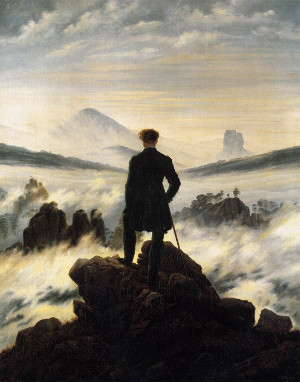

In [274]:
IPython.display.Image("/home/sam1902/Pictures/WandererAboveTheSeaOfFogResized.jpg")

Image original size:  (1399, 1100)
Resampling factor (2.073624017155111, 2.090909090909091)
Image resized : (2901, 2300)
Max intensity:  1.0
Min intensity:  0.0


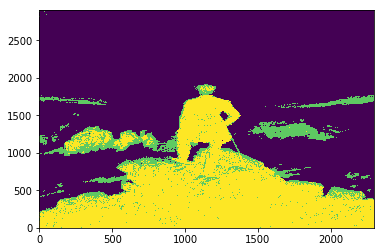

In [256]:
imgMat = loadPicture(size=(2901,2300), file="/home/sam1902/Pictures/WandererAboveTheSeaOfFog.jpg")

## Generate spectrogram from image
The spectrogram is a graph representing the frequencies and their intensity relative to the progress of the sound. It can be obtained by computing the Fourier Transform of the sound at each soundframe.

Therefore, to craft a sound that'll render the desired spectrogram we have to play a set of different sound which each individual frequency is related to the position of the pixel in the original image, and of which each intensity is related to the pixel intensity at this point.

To do so, we first load the image and resize it such that each column of pixel correspond to a frame of which we've got `max_frame` amount, and each row correspond to a frequency in the `steppingSpectrum`, which is essentially the maximum frequency allowed, divided by the step between each frequency band. We can further tune the frequency range if we want our custom spectrogram to appear more up or down the frequency spectrum, but for now lets just use the full spectrum.

Then, we multiply each pixel value (which was previously scaled between 0 and 1) by the `max_intensity` so that each pixel value is now the intensity of the pure sound to play.

Finally, we compute each soundframe by iterating through each column of the image and, for each pixel in it (which correspond each to a distinct band of frequencies) we add to the value of the sound value of that frame the sound of the pure wave corresponding to this range of frequencies, but we walk across these frequencies in substep of 1000 Hz. Strangely, the higher is this number the less "spaced" the drawing appears on the spectrogram. You can try lowering it to see what I mean.

Then, after iterating though each pixel we divide the sum of their values by the amount of individual values summed (divide once to avoid high computational cost). To conclude, we write this value as the frame's value and go to the next frame.

By doing that for every column of pixel, we can recreate the image in the spectrogram. Tadaaaa.

---

### Addendum

Except as it turns out, we should theoretically run into a pretty big problem which has a sweet name: the uncertainty principle. Except for some reason we don't, which is strange and I haven't found out why yet.

The fact is that spectrogram is computed by decomposing the sum of frequency that make a soundframe, but if that sum of frequency variates a lot between the current soundframe and the next, it's hard to tell what were the frequency in the current frame. This is called the uncertainty principle: if you can observe a wave for a very short amount of time, you cannot accurately tell which frequencies it was made of (uncertain) and when you observe it for long enough (a.k.a. stays the same for long enough) you can tell more accurately.

Therefore, to "solve" the problem that the uncertainty principle creates, we have to extend the periode during which we keep the same value so that the Fourier transform knows - and is certain - about which frequencies were in the sound and the spectrogram comes out crisps and clear.

To do that we simply should insert the same frame repeatedly, except when I try it doesn't do as expected, which is strange ¯\\\_(ツ)_/¯

In [262]:
def genSoundFromImage(file, output="sound.wav", duration=5.0, sampleRate=44100.0):
    wavef = wave.open(output,'w')
    wavef.setnchannels(1) # mono
    wavef.setsampwidth(2) 
    wavef.setframerate(sampleRate)
    
    max_frame = int(duration * sampleRate)
    max_freq = 22000 # Hz
    max_intensity = 32767
    
    stepSize = 400 # Hz
    steppingSpectrum = int(max_freq/stepSize)
    
    imgMat = loadPicture((steppingSpectrum, max_frame), file, verbose=0)
    imgMat *= max_intensity
    print("Input: ", file)
    print("Duration (in seconds): ", duration)
    print("Sample rate: ", sampleRate)
    print("Computing each soundframe sum value..")
    for frame in range(max_frame):
        if frame % 60 == 0: # Only print once in a while
            IPython.display.clear_output(wait=True)
            print("Progress: ==> {:.2%}".format(frame/max_frame), end="\r")
        signalValue, count = 0, 0
        for step in range(steppingSpectrum):
            intensity = imgMat[step, frame]
            if intensity == 0:
                continue
            # nextFreq is less than currentFreq
            currentFreq = max_freq - step * stepSize
            nextFreq = max_freq - (step+1) * stepSize
            if nextFreq < 0: # If we're at the end of the spectrum
                nextFreq = 0
            for freq in range(nextFreq, currentFreq, 1000): # substep of 1000 Hz is good
                signalValue += intensity*math.cos(freq * 2 * math.pi * float(frame) / float(sampleRate))
                count += 1
        if count == 0: count = 1
        signalValue /= count
        
        data = struct.pack('<h', int(signalValue))
        wavef.writeframesraw( data )
        
    wavef.writeframes(''.encode())
    wavef.close()
    print("\nProgress: ==> 100%")
    print("Output: ", output)

In [260]:
genSoundFromImage(file="/home/sam1902/Pictures/WandererAboveTheSeaOfFog.jpg")

Progress: ==> 99.97%
Progress: ==> 100%
Output:  sound.wav


File:  sound.wav
Sample rate (Hz):  44100


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:7176: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


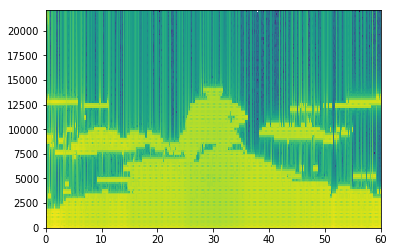

In [259]:
plotSpectrogram()

### Thanks for reading !